# Amenity Detection with VGGnet-16

Submitted by
1. Venna Paul Jaswanth Reddy
2. Pranav Krishnan

importing the data from kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d akkithetechie/furniture-detector

100% 232M/232M [00:02<00:00, 123MB/s]
100% 232M/232M [00:02<00:00, 104MB/s]


In [ ]:
! unzip furniture-detector.zip

Streaming output truncated to the last 5000 lines.
  inflating: furniture-images/img/train/table/00000295.jpg  
  inflating: furniture-images/img/train/table/00000296.jpg  
  inflating: furniture-images/img/train/table/00000297.jpg  
  inflating: furniture-images/img/train/table/00000298.jpg  
  inflating: furniture-images/img/train/table/00000299.jpg  
  inflating: furniture-images/img/train/table/00000300.jpg  
  inflating: furniture-images/img/train/table/00000301.jpg  
  inflating: furniture-images/img/train/table/00000302.jpg  
  inflating: furniture-images/img/train/table/00000303.jpg  
  inflating: furniture-images/img/train/table/00000304.jpg  
  inflating: furniture-images/img/train/table/00000305.jpg  
  inflating: furniture-images/img/train/table/00000306.jpg  
  inflating: furniture-images/img/train/table/00000307.jpg  
  inflating: furniture-images/img/train/table/00000308.jpg  
  inflating: furniture-images/img/train/table/00000309.jpg  
  inflating: furniture-images/img/

### importing modules 


In [ ]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

In [ ]:
from keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

### Data Exploration

In [ ]:
direc = Path('/content/furniture-images/img')
filepaths = list(direc.glob(r'**/*.jpg'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,/content/furniture-images/img/train/swivelchai...,swivelchair
1,/content/furniture-images/img/train/bed/000008...,bed
2,/content/furniture-images/img/train/bed/000007...,bed
3,/content/furniture-images/img/train/sofa/00000...,sofa
4,/content/furniture-images/img/train/sofa/00000...,sofa


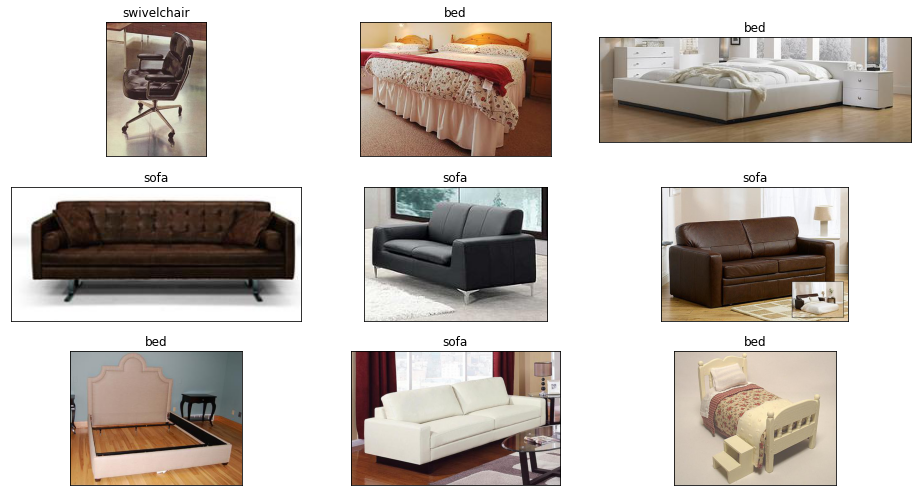

In [ ]:
import matplotlib.pyplot as plt
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()

In [ ]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")

 Count of Rows : 4447 
 Count of Columns : 2 


In [ ]:
img_df['Labels'].value_counts(ascending=True)

table           447
chair          1000
swivelchair    1000
bed            1000
sofa           1000
Name: Labels, dtype: int64

### Generating train ,test and validation dataset

In [ ]:
train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15


x_train, x_test = train_test_split(img_df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(f'Shape of Training Data : ',x_train.shape)
print(f'Shape of Testing Data : ',x_test.shape)
print(f'Shape of Validation Data : ',x_val.shape)
x_testt = x_test.copy()

Shape of Training Data :  (3335, 2)
Shape of Testing Data :  (668, 2)
Shape of Validation Data :  (444, 2)


In [ ]:
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

img_size=(224, 224)    

x_train = img_datagen.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 3335 validated image filenames belonging to 5 classes.
Found 668 validated image filenames belonging to 5 classes.
Found 444 validated image filenames belonging to 5 classes.


In [ ]:
img_width, img_height = 224, 224

### Model creation

In [ ]:
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape = (img_height, img_width,3)
                   )

In [ ]:
len(base_model.layers)

19

In [ ]:
def build_model(base_model, dropout, fc_layers, num_classes):
  for each_layer in base_model.layers:
    each_layer.trainable = True
  
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)

  # Fine-tune from this layer onwards
  fine_tune_at = 100

  ## freeze the bafore layers of fine tune at number in base model
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

  for fc in fc_layers:
    x = Dense(units=fc, activation='relu')(x)
    x = Dropout(dropout)(x)

  ## output layer with softmax activation function
  predictions = Dense(num_classes, activation='softmax')(x)

  final_model = Model(inputs = base_model.input, outputs = predictions)
  return final_model


In [ ]:
class_list = ['bed', 'chair', 'sofa', 'swivelchair', 'table']

In [ ]:
FC_LAYERS = [1024, 1024]
dropout = 0.3

model = build_model(base_model, dropout, FC_LAYERS, len(class_list))

In [ ]:
adam = Adam(learning_rate=0.00001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fit = model.fit(x_train,
                validation_data = x_val,
                epochs = 10, callbacks=Callback)

Epoch 1/10
105/105 [==============================] - 51s 373ms/step - loss: 1.5560 - accuracy: 0.2981 - val_loss: 1.3940 - val_accuracy: 0.6959
Epoch 2/10
105/105 [==============================] - 28s 266ms/step - loss: 1.4130 - accuracy: 0.4405 - val_loss: 1.2460 - val_accuracy: 0.7680
Epoch 3/10
105/105 [==============================] - 28s 267ms/step - loss: 1.2890 - accuracy: 0.5532 - val_loss: 1.0986 - val_accuracy: 0.8243
Epoch 4/10
105/105 [==============================] - 28s 268ms/step - loss: 1.1636 - accuracy: 0.6336 - val_loss: 0.9618 - val_accuracy: 0.8266
Epoch 5/10
105/105 [==============================] - 28s 268ms/step - loss: 1.0395 - accuracy: 0.6981 - val_loss: 0.8439 - val_accuracy: 0.8288
Epoch 6/10
105/105 [==============================] - 28s 268ms/step - loss: 0.9213 - accuracy: 0.7292 - val_loss: 0.7385 - val_accuracy: 0.8333
Epoch 7/10
105/105 [==============================] - 28s 268ms/step - loss: 0.8210 - accuracy: 0.7544 - val_loss: 0.6499 - val_ac

### Model Evalution

In [ ]:
accuracy = mo_fit.history['accuracy']
loss = mo_fit.history['loss']
validation_loss = mo_fit.history['val_loss']
validation_accuracy = mo_fit.history['val_accuracy']


Text(0.5, 1.0, 'Accuracy : Training Vs Validation ')

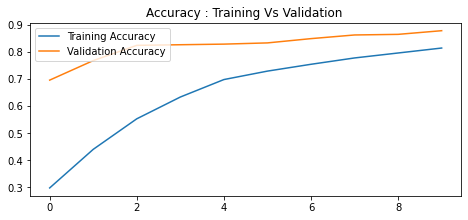

In [ ]:
plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')


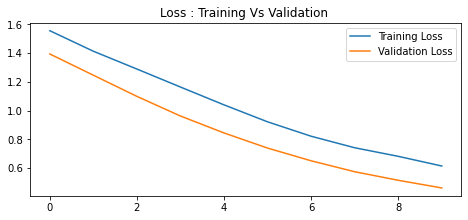

In [ ]:
plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()

### Prediction


In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline


In [ ]:
def print_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor = preprocess_input(img_tensor)
    featuremap = model.predict(img_tensor)
    index = np.argmax(featuremap)
    print(class_list[index])
    plt.imshow(img)


chair


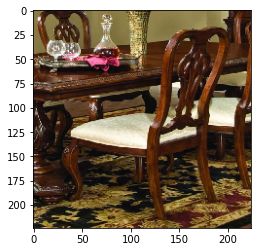

In [ ]:
img_path = '/content/furniture-images/img/val/chair/00000047.jpg'
print_image(img_path)

bed


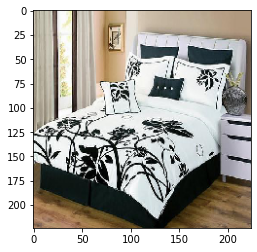

In [ ]:
img_path = '/content/furniture-images/img/val/bed/00000901.jpg'
print_image(img_path)

sofa


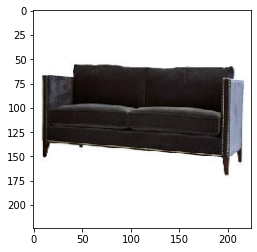

In [ ]:
img_path = '/content/furniture-images/img/val/sofa/00000225.jpg'
print_image(img_path)
